All the code will be uploaded in my github: https://github.com/AntoniaBonfa/gbsv_MC2

In [1]:
# general imports
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy import ndimage
from itertools import product

# Import images
items = cv.imread('images/souvenirs.jpg')
items = cv.cvtColor(items, cv.COLOR_BGR2RGB)



## Day 5: Define Segmentation Use Case & Select Image

For this task, I took a picture of some souvenirs I brought home from my travel. This image has been taken specifically for this task, so it is not a good representation of the real world. It contains some of the items I associate with my trip: the flower because they are everywhere and women often wear them in their hair as casual decoration. Various shells I collected at the beach, as well as two small pearls I bought for their unique shape and color. The last item  is technically not from French Polynesia, but from the Cook islands, which is also a tropical island: a triangle shaped coin, which is unique in the world and therefore a popular souvenir. I only included it because it might produce an intersting skeleton (and it's a fun souvenir to show off).

In general, a practical use case for some of these objects could be for example measuring and counting pearls to be able to sort them easily according to their value: as Polynesia produces a lot of pearls you can find bins full of lesser quality pearls at markets which are priced according to their purity, size and color. Being able to automatically measure them from an image could be therefore helpful for sorting. As my image only contains two pearls (which are both low quality and only cost around 10€) I don't expect that kind of insight from my image.

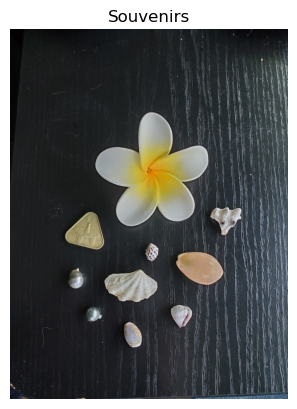

In [2]:
plt.imshow(items)
plt.axis('off')
plt.title('Souvenirs')
plt.show()